In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

## Introduction

In this notebook, we will examine a simulated task focused on **word production**. The real task involves a study of individuals with **aphasia** — a language disorder often resulting from a stroke or head injury. 

In our simulated task, participants are shown an image, such as that of a cat, and asked to identify it. Responses can vary, for instance, a participant might:

1. correctly identify the image as a *cat*,
2. produce a non-word that has a phonological relation to the target (i.e., a **neologism**), such as *cag*,
3. provide a semantically unrelated, yet phonologically similar word like *hat* (i.e., a **formal** mistake),
4. offer a semantically and phonologically similar but incorrect identification such as *rat* (i.e., a **mixed** mistake), or
5. omit the response altogether or provide a response that does not fit the above categories (e.g., a lengthy description)

Below, we we build a theoretical multiprocessing tree model (MPT) to explain the frequencies of these outcomes.

In [10]:
# Define a local RNG with a fixed seed
global_rng = np.random.default_rng(42)

# Fix true probabilities for simulation study
true_probs = {
    'correct': .42,
    'neologism': .1,
    'formal': .2,
    'mixed': .08,
    'other': .2 # 1 - rest
}


# Simulate data
num_trials = 100
y = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))
pd.DataFrame(y[:, None].T, columns=true_probs.keys(), index=['responses'])

,correct,neologism,formal,mixed,other
responses,47,12,19,4,18


## Modeling Multiple Responses via a Multinomial Likelihood

We will first build a baseline model that will estimate the underlying (latent) probabilities from the observed frequency data.

### Stan Code

In [13]:
baseline_program_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  // Our code here
  simplex[K] theta;

  
}

// Model is defining how the potential energy will be defined
model {
  
   theta ~ dirichlet(rep_vector(1, K));
   freqs ~ multinomial(theta);

  //Stan converts the above to approximately this, but sometimes this is needed explicitly
  //  when the log probability is needed
  //target += dirichlet_lpdf(probs | rep_vector(1, K));
  //target += multinomial_lpmf(freqs | probs);
}

// This section, for l = 1, ..., L
//     Takes each of the samples from the posterior y~p(y | theta_l)
generated quantities{
  // Obtaining predictions
  // Posterior predictive chain
  array[K] int preds = multinomial_rng(theta, N);
}
"""

### Model Fitting

In [14]:
# Prepare data
stan_dict = {
    'freqs': y,
    'N': num_trials,
    'K': y.shape[0]
}

# Compile model
posterior = stan.build(baseline_program_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: 78.8s, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000107 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
  Adjust your expectations accordingly!


### Model Inspection

In [15]:
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.458,0.049,0.365,0.550,0.000,0.000,11599.0,7548.0,1.0
theta[1],0.123,0.031,0.070,0.185,0.000,0.000,10828.0,7317.0,1.0
theta[2],0.190,0.038,0.119,0.264,0.000,0.000,10981.0,7229.0,1.0
theta[3],0.048,0.020,0.013,0.086,0.000,0.000,10940.0,7041.0,1.0
theta[4],0.180,0.037,0.110,0.249,0.000,0.000,11896.0,7946.0,1.0
preds[0],45.740,7.059,32.000,58.000,0.068,0.056,10763.0,8787.0,1.0
preds[1],12.344,4.513,4.000,20.000,0.046,0.037,9642.0,9365.0,1.0
preds[2],19.103,5.491,9.000,29.000,0.054,0.043,10364.0,9444.0,1.0
preds[3],4.779,2.941,0.000,10.000,0.029,0.028,10179.0,9169.0,1.0
preds[4],18.034,5.330,7.000,27.000,0.052,0.043,10401.0,9181.0,1.0


In [16]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,theta.4,theta.5,preds.1,preds.2,preds.3,preds.4,preds.5
draws,,,,,,,,,,,,,,,,,
0,-147.194866,0.807057,0.810009,3.0,7.0,0.0,149.714426,0.495933,0.148567,0.132523,0.050776,0.172201,47.0,12.0,15.0,5.0,21.0
1,-147.247641,1.000000,0.716083,2.0,3.0,0.0,149.620528,0.519857,0.101043,0.168810,0.025078,0.185212,53.0,12.0,13.0,3.0,19.0
2,-146.617806,0.779999,0.779520,3.0,7.0,0.0,150.749698,0.508183,0.131625,0.147051,0.039315,0.173825,60.0,11.0,11.0,2.0,16.0
3,-146.333389,0.984483,0.797420,2.0,7.0,0.0,146.901533,0.460310,0.099545,0.204372,0.033545,0.202228,51.0,11.0,21.0,1.0,16.0
4,-147.690475,0.942959,0.810009,3.0,7.0,0.0,149.002197,0.413749,0.090816,0.266472,0.042979,0.185984,36.0,5.0,28.0,3.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-149.166258,0.749179,0.797420,3.0,7.0,0.0,151.327967,0.368951,0.105227,0.180653,0.071710,0.273459,40.0,13.0,21.0,4.0,22.0
9996,-147.292827,0.997858,0.810009,3.0,7.0,0.0,149.316662,0.444122,0.123554,0.155755,0.032090,0.244478,33.0,14.0,21.0,5.0,27.0
9997,-149.916930,0.721062,0.716083,2.0,3.0,0.0,150.740093,0.335214,0.152001,0.264433,0.031100,0.217252,32.0,14.0,27.0,5.0,22.0


In [17]:
# Fix true probabilities for simulation study
true_probs = {
    'correct': .42,
    'neologism': .1,
    'formal': .2,
    'mixed': .08,
    'other': .2 
}

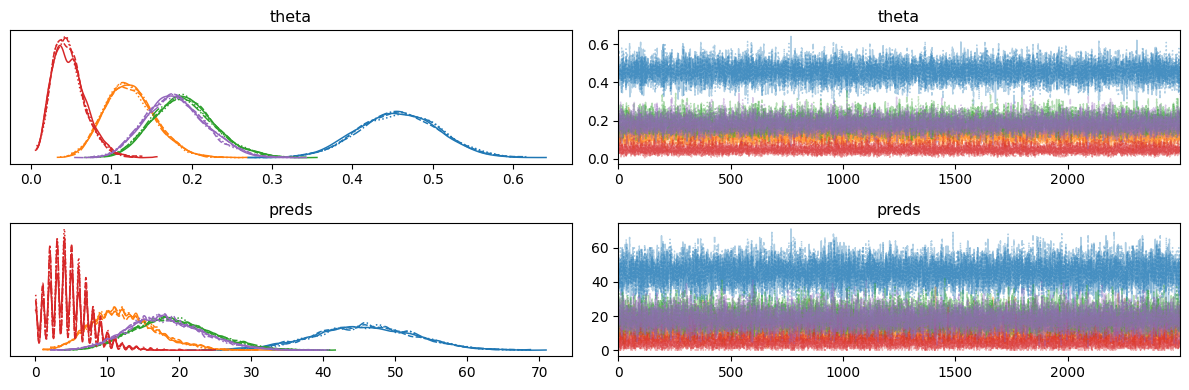

In [18]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit)
plt.tight_layout()

In [19]:
# Inspect all outputs
fit.to_frame().head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,theta.4,theta.5,preds.1,preds.2,preds.3,preds.4,preds.5
draws,,,,,,,,,,,,,,,,,
0,-147.194866,0.807057,0.810009,3.0,7.0,0.0,149.714426,0.495933,0.148567,0.132523,0.050776,0.172201,47.0,12.0,15.0,5.0,21.0
1,-147.247641,1.000000,0.716083,2.0,3.0,0.0,149.620528,0.519857,0.101043,0.168810,0.025078,0.185212,53.0,12.0,13.0,3.0,19.0
2,-146.617806,0.779999,0.779520,3.0,7.0,0.0,150.749698,0.508183,0.131625,0.147051,0.039315,0.173825,60.0,11.0,11.0,2.0,16.0
3,-146.333389,0.984483,0.797420,2.0,7.0,0.0,146.901533,0.460310,0.099545,0.204372,0.033545,0.202228,51.0,11.0,21.0,1.0,16.0
4,-147.690475,0.942959,0.810009,3.0,7.0,0.0,149.002197,0.413749,0.090816,0.266472,0.042979,0.185984,36.0,5.0,28.0,3.0,28.0


## Modeling Multiple Responses via a Multinomial Processing Tree (MPT) Model.

We will now build a process model that will estimate the underlying (latent) **process probabilities** from the observed frequency data.

Walker, Hickok, and Fridriksson (2018) created an MPT model that specifies a set of possible internal errors that lead to the various possible response types during a picture naming trial for aphasic patients. Here we’ll explore a simplification of the original model.

Our model assumes that when an attempt is made to produce a word, errors in production can arise at the whole word level (lexical level) or the morpheme level (phonological level). Semantic errors are assumed to arise from the lexical substitutions, and neologism errors from phonological substitutions. Real word responses that are phonologically related to the correct target word can arise from substitutions at the lexical or phonological level.

1. Walker, G. M., Hickok, G., & Fridriksson, J. (2018). A cognitive psychometric model for assessment of picture naming abilities in aphasia. *Psychological Assessment, 30*(6), 809. http://dx.doi.org/10.1037/pas0000529 

### Parameters and Model

The model is depicted in the following figure:

<img src="mpt_fig.png" width=65% height=65% />


The table below lists the four latent parameters and corresponding interpretations:


| Parameter | Description | 
| --- | --- |
| $a$ | Probability of initiating an attempt |
| $t$ | Probability of selecting a target word from a pool of candidates |
| $f$ | Probability of retrieving correct phonemes |
| $c$ | Probability of a phoneme change in the target word |

The table below lists the five types of responses (categories):


| Response (Category) | Description | Example | 
| --- | --- | --- |
| Correct | The response matches the target image. | cat |
| Neologism | The response is not a word, but it has a phonological relation to the target image. | cag |
| Formal | The response is a word with only a phonological relation to the target image. | hat |
| Mixed | The response is a word with both a semantic and phonological relation the target image. | rat |
| Other | All other responses, including omissions, descriptions, non-nouns, etc. | - |


### Simulating the Model

Practice: We first need to derive the equations for the category probabilities according to the graphical model.

In [ ]:
# Fix true parameters
true_params = {
    'a': 0.75,
    't': 0.9,
    'f': 0.8,
    'c': .2
}
a = true_params["a"]
t = true_params["t"]
f = true_params["f"]
c = true_params["c"]

# Fix true probabilities and simulate from model
num_trials = 120
true_probs = {
    'correct': a * t * f,
    'neologism': a * (1 - t) * (1 - f) * (1 - c) + a * t * (1 - f) * (1 - c),
    'formal': a * (1 - t) * (1 - f) * c + a * t * (1 - f) * c,
    'mixed': a * (1 - t) * f,
    'other': 1 - a
}

data = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))

In [ ]:
data

array([59, 15,  3, 12, 31])

In [31]:
mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  // Your code here
  int<lower=0, higher=1> a;
  int<lower=0, higher=1> t;
  int<lower=0, higher=1> f;
  int<lower=0, higher=1> c;
}

transformed parameters {
  simplex[K] theta;
  
  // Correct
  theta[1] = a * t * f;
  // Neologism
  //theta[2] = a*t*(1-f)*(1-c) + a*(1-t)*(1-f)*(1-c); // NOT NEEDED DUE TO SIMPLIFICATION
  theta[2] = (a * (1-f) * (1-c))
  // Formal
  theta[3] = a*(t*(1-f)*c + (1-t)*(1-f)*c);
  // Mixed
  theta[4] = a*(1-t)*f;
  // Other
  theta[5] = 1-a;
}

model {
  // Assuming uniform priors
  target += beta_lpdf(a | 1, 1);
  target += beta_lpdf(t | 1, 1);
  target += beta_lpdf(f | 1, 1);
  target += beta_lpdf(c | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [ ]:
### Compile, fit, and diagnose model
### Your code here

num_cats = 5

stan_dict = {
    'N': num_trials,
    'K': num_cats,
    'freqs': data
}

# Compile model
posterior = stan.build(baseline_program_code, data=stan_dict, random_seed=42)

Building...



Building: found in cache, done.

In [33]:
### Parameter recovery and predictions
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

az.summary(fit)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000135 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000138 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.92 seconds.
  Adjust your expectations accordingly!


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.200,0.164,0.0,0.503,0.002,0.002,8712.0,4605.0,1.0
theta[1],0.200,0.164,0.0,0.505,0.002,0.002,9021.0,4811.0,1.0
theta[2],0.200,0.162,0.0,0.500,0.002,0.002,9207.0,6298.0,1.0
theta[3],0.198,0.160,0.0,0.497,0.002,0.002,9204.0,6287.0,1.0
theta[4],0.201,0.164,0.0,0.509,0.002,0.002,10360.0,7186.0,1.0
preds[0],40.182,33.211,0.0,102.000,0.310,0.335,9048.0,4747.0,1.0
preds[1],40.039,33.146,0.0,102.000,0.315,0.343,9056.0,5451.0,1.0
preds[2],40.031,32.751,0.0,101.000,0.322,0.324,9350.0,6338.0,1.0
preds[3],39.625,32.437,0.0,101.000,0.332,0.328,9336.0,6880.0,1.0
preds[4],40.124,33.219,0.0,103.000,0.323,0.323,10602.0,7060.0,1.0


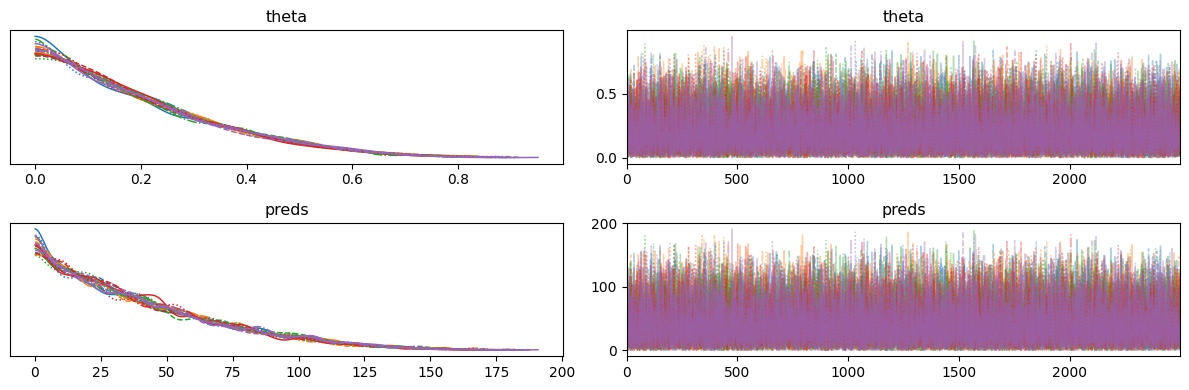

In [34]:
axarr = az.plot_trace(fit)
plt.tight_layout()

## Global Parameter Recovery Study

In [ ]:
### Our code here